# RQ_1: Virality Prediction and Multimodal Analysis

This notebook addresses Research Question 1 (RQ1) of the thesis, focusing on predicting TikTok video virality during the Nepal Local Election 2022 using multimodal data (audio, image, text, and metadata). We compute virality scores, perform sentiment analysis, cluster videos, and build predictive models to understand factors influencing virality. The analysis leverages a dataset of 3,000 classified videos (`NLP_TikTok_3k.csv`).

---

### 1. Import Libraries and Load Data

We begin by importing necessary libraries and loading the multimodal dataset.




In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap
import pickle
import emoji
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from sentence_transformers import SentenceTransformer

In [8]:

nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nimathing/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
df = pd.read_csv("data/NPL_TikTok_3k_with_Embeddings.csv", sep=";")

### 2. Compute Virality Scores and Labels
We calculate a virality score based on engagement metrics and label videos into Low, Medium, and High virality categories.



In [9]:
# Ensure required columns exist
required_columns = ['video_like_count', 'view_count', 'video_commentcount', 'video_sharecount', 'video_collectcount']
for col in required_columns:
    if col not in df.columns:
        raise KeyError(f"Missing required column: {col}")

# Calculate engagement rates
df['like_rate'] = df['video_like_count'] / df['view_count']
df['comment_rate'] = df['video_commentcount'] / df['view_count']
df['share_rate'] = df['video_sharecount'] / df['view_count']
df['collect_rate'] = df['video_collectcount'] / df['view_count']

# Handle missing or infinite values
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

# Compute virality score using weighted engagement metrics
df['virality_score'] = (
    0.35 * np.log1p(df['view_count']) +
    0.25 * np.log1p(df['like_rate']) +
    0.20 * np.log1p(df['comment_rate']) +
    0.15 * np.log1p(df['share_rate']) +
    0.05 * np.log1p(df['collect_rate'])
)

# Define thresholds for virality labels (Low: bottom 33%, High: top 33%)
high_thresh = df['virality_score'].quantile(0.66)
low_thresh = df['virality_score'].quantile(0.33)

def label_virality(score):
    if score <= low_thresh:
        return 0  # Low
    elif score >= high_thresh:
        return 2  # High
    else:
        return 1  # Medium

# Apply virality labels
df['virality_label'] = df['virality_score'].apply(label_virality)

# Display distribution of virality labels
print(df['virality_label'].value_counts())

virality_label
2    1008
1     978
0     978
Name: count, dtype: int64


In [78]:
import numpy as np
from sklearn.cluster import KMeans

# Sensitivity analysis for weights
weight_combinations = [
    [0.35, 0.25, 0.20, 0.15, 0.05],  # Original
    [0.20, 0.20, 0.20, 0.20, 0.20],  # Equal
    [0.25, 0.15, 0.15, 0.35, 0.10]   # Emphasize shares
]

for weights in weight_combinations:
    df['virality_score_temp'] = (
        weights[0] * np.log1p(df['view_count']) +
        weights[1] * np.log1p(df['like_rate']) +
        weights[2] * np.log1p(df['comment_rate']) +
        weights[3] * np.log1p(df['share_rate']) +
        weights[4] * np.log1p(df['collect_rate'])
    )
    high_thresh = df['virality_score_temp'].quantile(0.66)
    low_thresh = df['virality_score_temp'].quantile(0.33)
    df['virality_label_temp'] = df['virality_score_temp'].apply(
        lambda x: 0 if x <= low_thresh else (2 if x >= high_thresh else 1)
    )
    print(f"Weights: {weights}")
    print(df['virality_label_temp'].value_counts())

# K-means clustering
# Preprocess X_cluster to handle NaN and infinite values
X_cluster = df[['view_count', 'like_rate', 'comment_rate', 'share_rate', 'collect_rate']].apply(np.log1p)

# Drop rows with NaN or infinite values
X_cluster = X_cluster.replace([np.inf, -np.inf], np.nan).dropna()

# Ensure the indices of df and X_cluster align after dropping rows
df = df.loc[X_cluster.index]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['virality_cluster'] = kmeans.fit_predict(X_cluster)

# Print cluster counts
print(df['virality_cluster'].value_counts())

Weights: [0.35, 0.25, 0.2, 0.15, 0.05]
virality_label_temp
1    1000
2     997
0     967
Name: count, dtype: int64
Weights: [0.2, 0.2, 0.2, 0.2, 0.2]
virality_label_temp
1    1000
2     997
0     967
Name: count, dtype: int64
Weights: [0.25, 0.15, 0.15, 0.35, 0.1]
virality_label_temp
1    1000
2     997
0     967
Name: count, dtype: int64
virality_cluster
1    1772
0     751
2     408
Name: count, dtype: int64


### 3. Sensitivity Analysis of Virality Scores
We perform a sensitivity analysis by testing different weight combinations for the virality score and compare with K-means clustering.



In [10]:
# Sensitivity analysis with different weight combinations
weight_combinations = [
    [0.35, 0.25, 0.20, 0.15, 0.05],  # Original weights
    [0.20, 0.20, 0.20, 0.20, 0.20],  # Equal weights
    [0.25, 0.15, 0.15, 0.35, 0.10]   # Emphasize shares
]

for weights in weight_combinations:
    df['virality_score_temp'] = (
        weights[0] * np.log1p(df['view_count']) +
        weights[1] * np.log1p(df['like_rate']) +
        weights[2] * np.log1p(df['comment_rate']) +
        weights[3] * np.log1p(df['share_rate']) +
        weights[4] * np.log1p(df['collect_rate'])
    )
    high_thresh = df['virality_score_temp'].quantile(0.66)
    low_thresh = df['virality_score_temp'].quantile(0.33)
    df['virality_label_temp'] = df['virality_score_temp'].apply(
        lambda x: 0 if x <= low_thresh else (2 if x >= high_thresh else 1)
    )
    print(f"\nWeights: {weights}")
    print(df['virality_label_temp'].value_counts())

# Compare with equal weights explicitly
df['virality_score_equal'] = (
    0.2 * np.log1p(df['view_count']) +
    0.2 * np.log1p(df['like_rate']) +
    0.2 * np.log1p(df['comment_rate']) +
    0.2 * np.log1p(df['share_rate']) +
    0.2 * np.log1p(df['collect_rate'])
)

# Define thresholds for equal weights
high_thresh_equal = df['virality_score_equal'].quantile(0.66)
low_thresh_equal = df['virality_score_equal'].quantile(0.33)

def label_virality_equal(score):
    if score <= low_thresh_equal:
        return 0
    elif score >= high_thresh_equal:
        return 2
    else:
        return 1

df['virality_label_equal'] = df['virality_score_equal'].apply(label_virality_equal)

# Calculate agreement between original and equal weight labels
agreement = (df['virality_label'] == df['virality_label_equal']).mean()
print(f"\nAgreement between original and equal weight labels: {agreement:.2%}")

# K-means clustering on engagement metrics
X_cluster = df[['view_count', 'like_rate', 'comment_rate', 'share_rate', 'collect_rate']].apply(np.log1p)
X_cluster = X_cluster.replace([np.inf, -np.inf], np.nan).dropna()
df = df.loc[X_cluster.index]

kmeans = KMeans(n_clusters=3, random_state=42)
df['virality_cluster'] = kmeans.fit_predict(X_cluster)
print("\nK-means Clustering Results:")
print(df['virality_cluster'].value_counts())


Weights: [0.35, 0.25, 0.2, 0.15, 0.05]
virality_label_temp
2    1008
1     978
0     978
Name: count, dtype: int64

Weights: [0.2, 0.2, 0.2, 0.2, 0.2]
virality_label_temp
2    1008
1     978
0     978
Name: count, dtype: int64

Weights: [0.25, 0.15, 0.15, 0.35, 0.1]
virality_label_temp
2    1008
1     978
0     978
Name: count, dtype: int64

Agreement between original and equal weight labels: 99.53%

K-means Clustering Results:
virality_cluster
1    1778
0     766
2     420
Name: count, dtype: int64


### 4. Initial EDA: Creator and Content Distribution
We explore the distribution of creator followers, languages, regions, and re-stratify videos by virality score



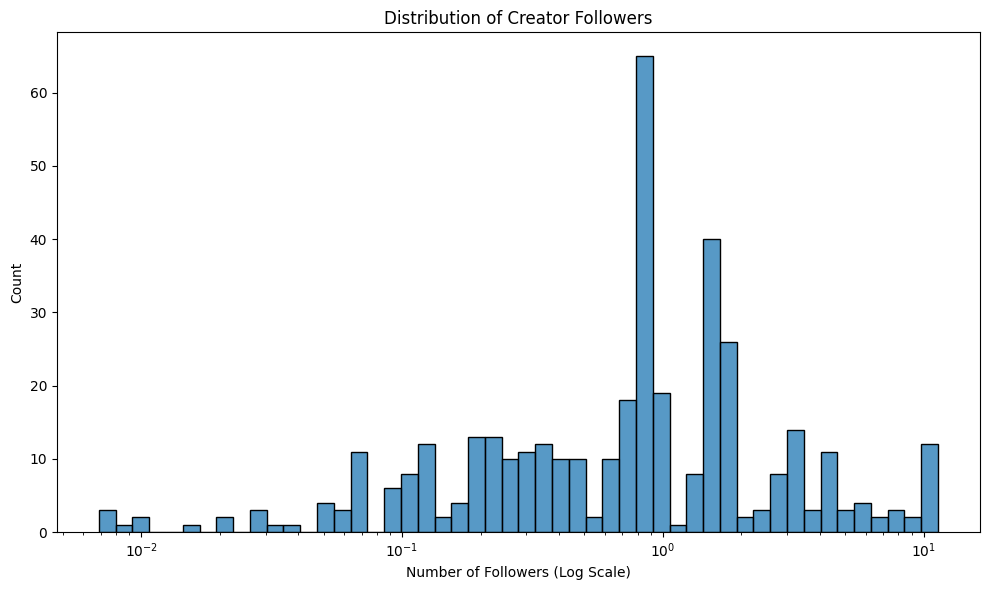


Detected Language Counts:
detected_language
ne         853
unknown    598
en         366
so         254
sw         247
id         229
tl         107
fr          37
et          36
cy          36
es          21
fi          19
sl          19
hr          16
lt          14
it          14
nl          12
ca          10
de           9
no           9
sk           8
da           8
sq           7
pt           6
af           6
ro           5
tr           5
ja           3
hu           3
sv           2
vi           2
lv           1
cs           1
pl           1
Name: count, dtype: int64

Region Code Counts:
region_code
np    2510
NP     454
Name: count, dtype: int64

New Stratum Distribution:
new_stratum
low       1778
medium    1037
high       149
Name: count, dtype: int64


In [11]:
# Plot distribution of creator followers (log scale)
plt.figure(figsize=(10, 6))
sns.histplot(df['followers'], bins=50, log_scale=True)
plt.title('Distribution of Creator Followers')
plt.xlabel('Number of Followers (Log Scale)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Display language and region distributions
print("\nDetected Language Counts:")
print(df['detected_language'].value_counts())
print("\nRegion Code Counts:")
print(df['region_code'].value_counts())

# Re-stratify by virality score with tighter thresholds
high_thresh = df['virality_score'].quantile(0.95)
medium_thresh = df['virality_score'].quantile(0.60)
df['new_stratum'] = pd.cut(
    df['virality_score'],
    bins=[-float('inf'), medium_thresh, high_thresh, float('inf')],
    labels=['low', 'medium', 'high']
)
print("\nNew Stratum Distribution:")
print(df['new_stratum'].value_counts())

### 5. Temporal Analysis: Convert to Nepali Timezone
We convert timestamps to Nepali time (NPT, UTC+5:45) and extract time-based features.



In [12]:
# Convert timestamps to datetime in UTC
df['video_time_created'] = pd.to_datetime(df['video_time_created'], utc=True)
df['author_create_time'] = pd.to_datetime(df['author_create_time'], utc=True)

# Add 5 hours 45 minutes for Nepali Time
npt_offset = timedelta(hours=5, minutes=45)
df['video_time_created_npt'] = df['video_time_created'] + npt_offset
df['author_create_time_npt'] = df['author_create_time'] + npt_offset

# Extract time features
df['video_hour_npt'] = df['video_time_created_npt'].dt.hour
df['video_dayofweek_npt'] = df['video_time_created_npt'].dt.day_name()
df['video_date_npt'] = df['video_time_created_npt'].dt.date

### 6. Correlations and Time-Adjusted Virality
We compute correlations between engagement metrics and adjust the virality score for time since posting.
python



In [13]:
# Compute correlations between engagement metrics and virality score
correlation_matrix = df[['view_count', 'like_rate', 'comment_rate', 'share_rate', 'collect_rate', 'virality_score']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Adjust virality score for time since posting
comparison_date = pd.to_datetime('2022-01-31', utc=True)
df['days_since_posting'] = (comparison_date - df['video_time_created_npt']).dt.days
df['adjusted_virality_score'] = df['virality_score'] / (df['days_since_posting'] + 1)
print("\nAdjusted Virality Score Stats:")
print(df['adjusted_virality_score'].describe())

Correlation Matrix:
                view_count  like_rate  comment_rate  share_rate  collect_rate  \
view_count        1.000000  -0.192492     -0.015859   -0.014563     -0.014482   
like_rate        -0.192492   1.000000     -0.084345   -0.065605     -0.079913   
comment_rate     -0.015859  -0.084345      1.000000    0.317042      0.350919   
share_rate       -0.014563  -0.065605      0.317042    1.000000      0.249915   
collect_rate     -0.014482  -0.079913      0.350919    0.249915      1.000000   
virality_score    0.504815  -0.514688     -0.148740   -0.131395     -0.155143   

                virality_score  
view_count            0.504815  
like_rate            -0.514688  
comment_rate         -0.148740  
share_rate           -0.131395  
collect_rate         -0.155143  
virality_score        1.000000  

Adjusted Virality Score Stats:
count    2964.000000
mean       -0.031562
std         0.011359
min        -0.094091
25%        -0.037781
50%        -0.028241
75%        -0.023593
ma

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Check correlations
correlation_matrix = df[['view_count', 'like_rate', 'comment_rate', 'share_rate', 'collect_rate', 'virality_score']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Time-adjusted virality score
# Ensure the comparison date is timezone-aware
comparison_date = pd.to_datetime('2022-01-31', utc=True)
df['days_since_posting'] = (comparison_date - df['video_time_created_npt']).dt.days  # Adjust end date to election period
df['adjusted_virality_score'] = df['virality_score'] / (df['days_since_posting'] + 1)
print("\nAdjusted Virality Score Stats:")
print(df['adjusted_virality_score'].describe())

# Rerun clustering (to be done after sentiment analysis)
X_cluster = df[['view_count', 'like_rate', 'comment_rate', 'share_rate', 'collect_rate'] +
               [col for col in df.columns if '_sent_' in col]].apply(np.log1p)
kmeans = KMeans(n_clusters=3, random_state=42)
df['virality_cluster'] = kmeans.fit_predict(X_cluster)
print("\nClustering Results:")
#print(df['virality_cluster'].value_counts())

Correlation Matrix:
                view_count  like_rate  comment_rate  share_rate  collect_rate  \
view_count        1.000000  -0.198851     -0.107346   -0.043565     -0.041365   
like_rate        -0.198851   1.000000      0.465598    0.146437      0.199920   
comment_rate     -0.107346   0.465598      1.000000    0.168001      0.150424   
share_rate       -0.043565   0.146437      0.168001    1.000000      0.138928   
collect_rate     -0.041365   0.199920      0.150424    0.138928      1.000000   
virality_score    0.520462  -0.592161     -0.266720   -0.114496     -0.114905   

                virality_score  
view_count            0.520462  
like_rate            -0.592161  
comment_rate         -0.266720  
share_rate           -0.114496  
collect_rate         -0.114905  
virality_score        1.000000  

Adjusted Virality Score Stats:
count    2931.000000
mean       -0.031845
std         0.011100
min        -0.094091
25%        -0.037898
50%        -0.028425
75%        -0.023699
ma

### 7. Text Preprocessing and Sentiment Analysis
We clean the text data, perform sentiment analysis on audio transcripts, image descriptions, and video descriptions, and verify multilingual embeddings.



#### 7.1 Text Cleaning



In [14]:
# Function to clean text and convert emojis
def clean_text_improved(text):
    if pd.isna(text):
        return ''
    text = str(text)
    text = emoji.demojize(text, delimiters=(':', ':'))
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s:]', '', text)
    text = text.lower()
    return text

# Apply cleaning to audio and image text
df['clean_audio_text'] = df['audio_transcript_np'].apply(clean_text_improved)
df['clean_image_description'] = df['image_analysis'].apply(clean_text_improved)

#### 7.2 Verify Multilingual Embeddings



In [15]:
# Load multilingual embedding model
model = SentenceTransformer("BAAI/bge-m3", trust_remote_code=True)
sample_nepali = ["नेपालको निर्वाचन २०२२ मा उत्साहजनक सहभागिता"]  # Example Nepali text
nepali_embedding = model.encode(sample_nepali)
print("Nepali embedding shape:", nepali_embedding.shape)

Nepali embedding shape: (1, 1024)


#### 7.3 Sentiment Analysis



In [16]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import re

# Initialize VADER for English
vader = SentimentIntensityAnalyzer()

# Initialize multilingual sentiment model with explicit tokenizer
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    multilingual_sentiment = pipeline(
        "sentiment-analysis",
        model=model,
        tokenizer=tokenizer,
        max_length=512,
        truncation=True
    )
except Exception as e:
    print(f"Error with {model_name}: {e}")
    print("Falling back to nlptown/bert-base-multilingual-uncased-sentiment")
    model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    multilingual_sentiment = pipeline(
        "sentiment-analysis",
        model=model,
        tokenizer=tokenizer,
        max_length=512,
        truncation=True
    )

# Set TOKENIZERS_PARALLELISM to avoid warnings
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define election-related keywords
election_keywords = [
    "election", "vote", "candidate", "party", "nepal 2022", "democracy", "campaign", "ballot", "politics",
    "nirvachan", "matdan", "ummidwar", "dal", "loktantra", "prachar", "matpatra",
    "निर्वाचन", "मतदान", "उम्मेदवार", "दल", "लोकतन्त्र", "प्रचार", "मतपत्र"
]

# Extract election-related text
def extract_election_text(text, keywords):
    if pd.isna(text) or not text:
        return ""
    sentences = re.split(r'[.!?]+', text)
    election_sentences = [s for s in sentences if any(k.lower() in s.lower() for k in keywords)]
    return " ".join(election_sentences) if election_sentences else text

# Compute sentiment scores
def compute_sentiment(text, is_english=True):
    if not text:
        return {'pos': 0.0, 'neg': 0.0, 'neu': 0.0, 'compound': 0.0}

    election_text = extract_election_text(text, election_keywords)
    text_to_analyze = election_text if election_text else text

    if is_english:
        # VADER for English
        scores = vader.polarity_scores(text_to_analyze)
    else:
        # Multilingual model
        try:
            result = multilingual_sentiment(text_to_analyze)[0]
            label = result['label']
            score = result['score']
            if 'positive' in label.lower():
                scores = {'pos': score, 'neg': 0.0, 'neu': 0.0, 'compound': score}
            elif 'negative' in label.lower():
                scores = {'pos': 0.0, 'neg': score, 'neu': 0.0, 'compound': -score}
            else:
                scores = {'pos': 0.0, 'neg': 0.0, 'neu': score, 'compound': 0.0}
        except Exception:
            scores = {'pos': 0.0, 'neg': 0.0, 'neu': 0.0, 'compound': 0.0}

    return scores

# Apply sentiment analysis
df['is_english'] = df['detected_language'] == 'en'
for modality in ['clean_audio_text', 'clean_image_description', 'video_description_en']:
    modality_sentiments = df.apply(
        lambda row: compute_sentiment(row[modality], row['is_english']),
        axis=1
    )
    df[f'{modality}_sent_pos'] = modality_sentiments.apply(lambda x: x['pos'])
    df[f'{modality}_sent_neg'] = modality_sentiments.apply(lambda x: x['neg'])
    df[f'{modality}_sent_neu'] = modality_sentiments.apply(lambda x: x['neu'])
    df[f'{modality}_sent_compound'] = modality_sentiments.apply(lambda x: x['compound'])

# Check distribution of sentiment scores
sentiment_cols = [col for col in df.columns if '_sent_' in col]
for col in sentiment_cols:
    print(f"\nMean {col} by virality_label:")
    print(df.groupby('virality_label')[col].mean())

# Standardize sentiment features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[sentiment_cols] = scaler.fit_transform(df[sentiment_cols])

Error with cardiffnlp/twitter-xlm-roberta-base-sentiment: Converting from Tiktoken failed, if a converter for SentencePiece is available, provide a model path with a SentencePiece tokenizer.model file.Currently available slow->fast converters: ['AlbertTokenizer', 'BartTokenizer', 'BarthezTokenizer', 'BertTokenizer', 'BigBirdTokenizer', 'BlenderbotTokenizer', 'CamembertTokenizer', 'CLIPTokenizer', 'CodeGenTokenizer', 'ConvBertTokenizer', 'DebertaTokenizer', 'DebertaV2Tokenizer', 'DistilBertTokenizer', 'DPRReaderTokenizer', 'DPRQuestionEncoderTokenizer', 'DPRContextEncoderTokenizer', 'ElectraTokenizer', 'FNetTokenizer', 'FunnelTokenizer', 'GPT2Tokenizer', 'HerbertTokenizer', 'LayoutLMTokenizer', 'LayoutLMv2Tokenizer', 'LayoutLMv3Tokenizer', 'LayoutXLMTokenizer', 'LongformerTokenizer', 'LEDTokenizer', 'LxmertTokenizer', 'MarkupLMTokenizer', 'MBartTokenizer', 'MBart50Tokenizer', 'MPNetTokenizer', 'MobileBertTokenizer', 'MvpTokenizer', 'NllbTokenizer', 'OpenAIGPTTokenizer', 'PegasusTokenize

Device set to use mps:0



Mean clean_audio_text_sent_pos by virality_label:
virality_label
0    0.002774
1    0.005173
2    0.003464
Name: clean_audio_text_sent_pos, dtype: float64

Mean clean_audio_text_sent_neg by virality_label:
virality_label
0    0.001325
1    0.002460
2    0.002360
Name: clean_audio_text_sent_neg, dtype: float64

Mean clean_audio_text_sent_neu by virality_label:
virality_label
0    0.288701
1    0.310337
2    0.301464
Name: clean_audio_text_sent_neu, dtype: float64

Mean clean_audio_text_sent_compound by virality_label:
virality_label
0    0.002051
1    0.003275
2    0.005207
Name: clean_audio_text_sent_compound, dtype: float64

Mean clean_image_description_sent_pos by virality_label:
virality_label
0    0.005749
1    0.006557
2    0.008145
Name: clean_image_description_sent_pos, dtype: float64

Mean clean_image_description_sent_neg by virality_label:
virality_label
0    0.001733
1    0.001249
2    0.001803
Name: clean_image_description_sent_neg, dtype: float64

Mean clean_image_descript

### 8. Clustering with Sentiment Features
We re-run K-means clustering, incorporating sentiment features alongside engagement metrics.



In [17]:
# Cluster with engagement and sentiment features
X_cluster = df[['view_count', 'like_rate', 'comment_rate', 'share_rate', 'collect_rate'] +
               [col for col in df.columns if '_sent_' in col]].apply(np.log1p)
X_cluster = X_cluster.replace([np.inf, -np.inf], np.nan).dropna()
df = df.loc[X_cluster.index]

kmeans = KMeans(n_clusters=3, random_state=42)
df['virality_cluster'] = kmeans.fit_predict(X_cluster)
print("\nClustering Results with Sentiment Features:")
print(df['virality_cluster'].value_counts())


Clustering Results with Sentiment Features:
virality_cluster
1    1625
0     660
2     410
Name: count, dtype: int64


### 9. Feature Engineering and Model Preparation
We prepare features for modeling by encoding categorical variables and standardizing numerical features.



### 9.1 Load Dataset with Embeddings



In [18]:
# Load dataset with embeddings
df = pd.read_csv("data/NPL_TikTok_3k_with_Embeddings.csv", sep=";")
if df.columns.duplicated().any():
    print(f"Removing duplicate columns: {df.columns[df.columns.duplicated()].tolist()}")
    df = df.loc[:, ~df.columns.duplicated(keep='first')]

### 9.2 Encode Categorical Features



In [19]:
# Define categorical features
categorical_cols = ['video_dayofweek_npt', 'creator_tier', 'video_diversification_id']
categorical_cols = [col for col in categorical_cols if col in df.columns]

# Remove existing encoded columns to avoid re-encoding
existing_encoded = [col for col in df.columns if col.startswith(('video_dayofweek_npt_', 'creator_tier_'))]
if existing_encoded:
    print(f"Dropping existing encoded columns: {existing_encoded}")
    df = df.drop(columns=existing_encoded)

# Encode categorical features
if categorical_cols:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_data = encoder.fit_transform(df[categorical_cols])
    encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df.index)
    df = pd.concat([df, encoded_df], axis=1)
else:
    encoded_cols = []
    print("Warning: No categorical columns found. Skipping encoding.")

Dropping existing encoded columns: ['video_dayofweek_npt_Friday', 'video_dayofweek_npt_Monday', 'video_dayofweek_npt_Saturday', 'video_dayofweek_npt_Sunday', 'video_dayofweek_npt_Thursday', 'video_dayofweek_npt_Tuesday', 'video_dayofweek_npt_Wednesday', 'creator_tier_macro', 'creator_tier_mega', 'creator_tier_micro', 'creator_tier_regular']


### 9.3 Standardize Numerical Features



In [20]:
# Define numerical features
numerical_cols = [
    'followers', 'following', 'user_like_count', 'Video_count', 'author_verified',
    'used_effect', 'is_original_music', 'video_hour_npt', 'video_duet_enabled',
    'video_stitch_enabled', 'audio_word_count', 'image_word_count', 'hashtag_count',
    'author_days_on_platform',
    'clean_audio_text_sent_pos', 'clean_audio_text_sent_neg',
    'clean_audio_text_sent_neu', 'clean_audio_text_sent_compound'
] + [col for col in df.columns if col.startswith(('audio_pca_', 'image_pca_', 'desc_pca_'))]

# Verify numerical columns exist
numerical_cols = [col for col in numerical_cols if col in df.columns]

# Convert non-numeric columns to numeric
non_numeric_cols = [col for col in numerical_cols if df[col].dtype not in ['int64', 'float64', 'int32', 'float32']]
for col in non_numeric_cols:
    try:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isna().all():
            print(f"Excluding {col}: conversion resulted in all NaN.")
            numerical_cols.remove(col)
    except:
        print(f"Excluding {col}: cannot convert to numeric.")
        numerical_cols.remove(col)

# Standardize numerical features
if numerical_cols:
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
else:
    print("Warning: No numerical columns available. Proceeding with encoded columns only.")

# Prepare features and target
feature_cols = numerical_cols + (encoded_cols if len(encoded_cols) > 0 else [])
if not feature_cols:
    raise ValueError("No features for training.")
X = df[feature_cols]
y = df['virality_label']

# Handle missing values
X = X.fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (2074, 363)
y_train shape: (2074,)


### 10. Model Training and Evaluation



In [21]:
# Initialize models
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
xgb_model = XGBClassifier(random_state=42, eval_metric='mlogloss')
lgb_model = LGBMClassifier(random_state=42, verbosity=-1)

models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'LightGBM': lgb_model
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    y_pred_proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    print(f"{name} AUC-ROC (OvR):", auc)
    results[name] = {
        'accuracy': model.score(X_test, y_test),
        'macro_f1': classification_report(y_test, y_pred, output_dict=True)['macro avg']['f1-score'],
        'auc_roc': auc
    }

# Print comparison summary
print("\nModel Comparison Summary:")
print("| Model         | Accuracy | Macro Avg F1-score | AUC-ROC (OvR) |")
print("|---------------|----------|--------------------|---------------|")
for name, metrics in results.items():
    print(f"| {name:<13} | {metrics['accuracy']:.2f}     | {metrics['macro_f1']:.2f}               | {metrics['auc_roc']:.4f}        |")


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.68      0.59       294
           1       0.53      0.45      0.49       293
           2       0.73      0.61      0.67       303

    accuracy                           0.58       890
   macro avg       0.59      0.58      0.58       890
weighted avg       0.59      0.58      0.58       890

Random Forest AUC-ROC (OvR): 0.7549414018097572

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.66      0.62       294
           1       0.53      0.50      0.51       293
           2       0.70      0.65      0.68       303

    accuracy                           0.60       890
   macro avg       0.61      0.60      0.60       890
weighted avg       0.61      0.60      0.60       890

XGBoost AUC-ROC (OvR): 0.7948144103295253

LightGBM Classification Report:
              precision    recall  f1-score  

### 11. Hyperparameter Tuning and Feature Importance (XGBoost)
We tune the XGBoost model and analyze feature importance using SHAP.



11.1 Hyperparameter Tuning



In [23]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBClassifier(random_state=42, eval_metric='mlogloss')
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Evaluate performance
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
y_pred_proba = best_model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("AUC-ROC (OvR):", auc)


Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.70      0.63       294
           1       0.54      0.50      0.52       293
           2       0.73      0.64      0.68       303

    accuracy                           0.61       890
   macro avg       0.62      0.61      0.61       890
weighted avg       0.62      0.61      0.61       890

AUC-ROC (OvR): 0.8003940527479654


11.2 Feature Importance with SHAP



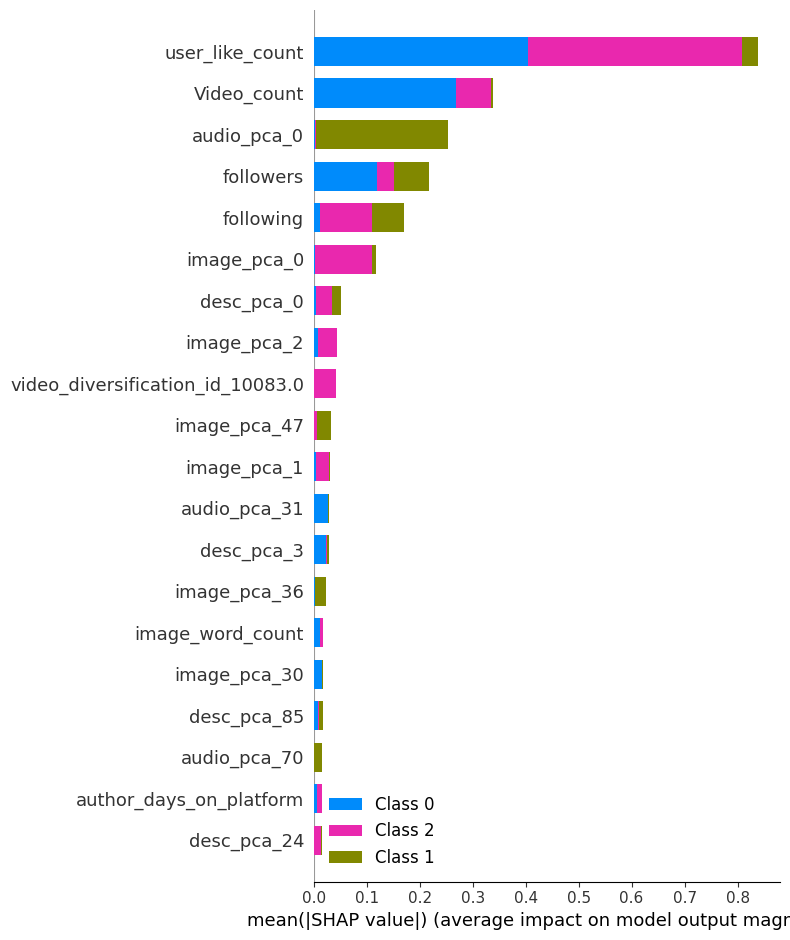

Mean SHAP value for audio: 0.001664734911173582
Mean SHAP value for image: 0.0023625383619219065
Mean SHAP value for text: 0.001891387510113418
Mean SHAP value for sender: 0.052635855972766876
Mean SHAP value for platform: 0.000542903842870146


In [24]:
# Compute SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

# Summary plot (top 10 features)
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Group features by modality and compute mean SHAP values
feature_groups = {
    'audio': [col for col in X_train.columns if col.startswith('audio_pca_')] +
             ['clean_audio_text_sent_pos', 'clean_audio_text_sent_neg',
              'clean_audio_text_sent_neu', 'clean_audio_text_sent_compound'],
    'image': [col for col in X_train.columns if col.startswith('image_pca_')],
    'text': [col for col in X_train.columns if col.startswith('desc_pca_')],
    'sender': ['followers', 'following', 'user_like_count', 'Video_count', 'author_verified',
               'author_days_on_platform', 'creator_tier_macro', 'creator_tier_mega',
               'creator_tier_micro', 'creator_tier_regular'],
    'platform': ['used_effect', 'is_original_music', 'video_hour_npt', 'video_duet_enabled',
                 'video_stitch_enabled', 'hashtag_count', 'audio_word_count', 'image_word_count'] +
                [col for col in X_train.columns if col.startswith(('video_dayofweek_npt_', 'video_diversification_id_'))]
}

for group, cols in feature_groups.items():
    valid_cols = [c for c in cols if c in X_train.columns]
    if valid_cols:
        group_shap = np.abs(shap_values[:, [X_train.columns.get_loc(c) for c in valid_cols]]).mean()
        print(f"Mean SHAP value for {group}: {group_shap}")

# Save model and SHAP values
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
np.save('Analysis/ViralityPrediction/shap_values.npy', shap_values)

11.3 Detailed SHAP Analysis for a Sample



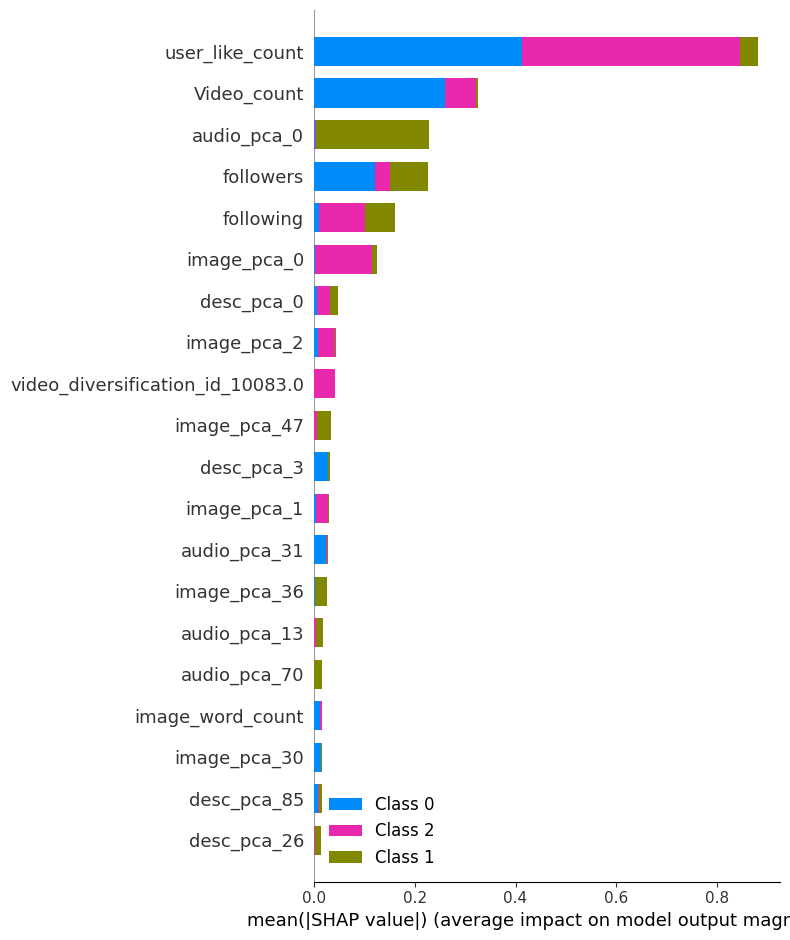

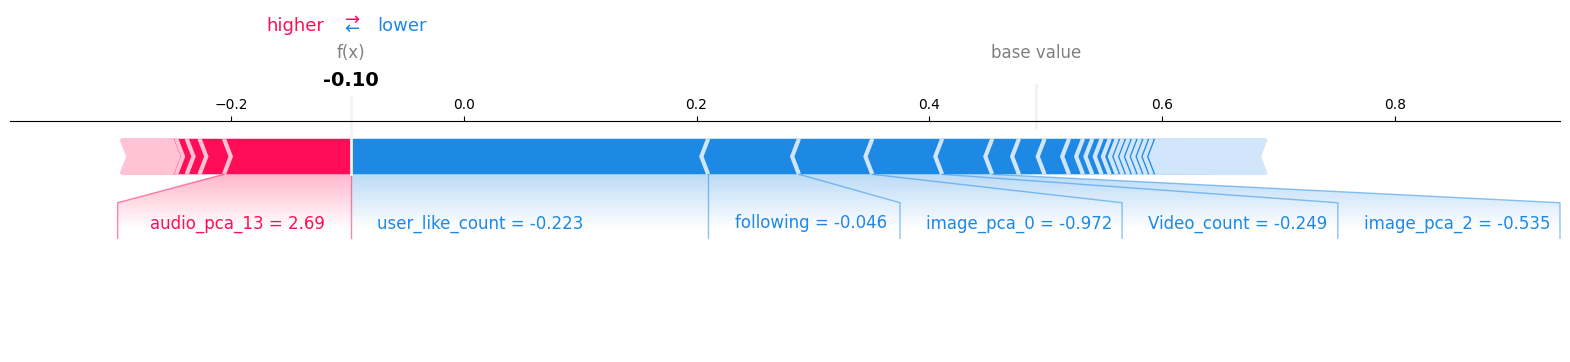

🎥 Video ID: 7094266409013759259
🖼️ Image Analysis: The image shows a man wearing a blue suit and white shirt, speaking or posing for a photo. There's text on the image, including "RAJAN KOIRALA FOR NAGARJUN" at the top and "RAJAN for" with some script text in blue at the bottom. There's also a comment in a speech bubble in a different script with some emojis.
🎶 Audio Transcript (NP): हामीले प्रतिबद्धताको हिसाबले बुदा नम्बर पाँचमा यहाँका धार्मिक, सांस्कृतिक र प्राकृतिक सम्पदाहरूको सूचीकरण गरेर यसको संरक्षण र प्रवर्द्धन गरिने भन्ने कुराहरू हामीले जोड तोडका साथ राखेका छौं। यसै अन्तरगत सबैभन्दा पहिला हामी नागर्जुन नगरपालिकाका तीन तिरबाट बनले घेरेको हुनाले यसमा साइकलिङ र हाइकिङ ट्र्याकहरूको निर्माण गर्छौं र हरेक वर्ष स्थानीय अर्थतन्त्रमा पनि केहि प्रभाव पर्नेगरी यहाँ बिभिन्न प्रतिस्पर्धाका खेलहरू अथवा हामीले साइकलिङका प्रतिस्पर्धाहरू गर्न सक्छौं, हाइकिङ र अन्य किसिमका खेलहरूलाई पनि हामी प्रवर्द्धन गर्न चाहन्छौं। त्यस्तैगरी कृषिमा नागर्जुन नगरपालिकाको पश्चिम भेगमा अलिकति सम्भाव्यताका बारेमा 

/var/folders/vz/qgddhj1d00b_xrxhd73v0fdc0000gn/T/ipykernel_38510/2304478812.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[X_test.index, 'virality_label_pred'] = y_pred


In [25]:
# Sample 100 videos for SHAP analysis
sample_data = X_test[feature_cols].sample(100, random_state=42)
shap_values = explainer.shap_values(sample_data)

# Visualize global feature importance
shap.summary_plot(shap_values, sample_data, plot_type="bar")

# Analyze a specific sample (index 35)
i = 35
shap.initjs()
decimals = 3
shap_values_sample = np.round(shap_values[i, :, 2], decimals)
features_rounded = np.round(sample_data.iloc[i], decimals)

# Create force plot
shap.force_plot(
    base_value=np.round(explainer.expected_value[2], decimals),
    shap_values=shap_values_sample,
    features=features_rounded,
    feature_names=sample_data.columns,
    matplotlib=True
)

# Display details of the sample
original_index = X_test.iloc[i].name
print("🎥 Video ID:", df.loc[original_index, "id"])
print("🖼️ Image Analysis:", df.loc[original_index, "image_analysis"])
print("🎶 Audio Transcript (NP):", df.loc[original_index, "audio_transcript_np"])
print("TikTok Video URL:", df.loc[original_index, "tiktokurl"])
print("📝 Description:", df.loc[original_index, "video_description_en"])
print("📊 Virality Score:", df.loc[original_index, "virality_score"])
print("🏷️ True Label:", df.loc[original_index, "virality_label"])
df.loc[X_test.index, 'virality_label_pred'] = y_pred
print("📊 Predicted Label:", df.loc[original_index, "virality_label_pred"])

### 12. Error Analysis

We analyze misclassified samples to understand model performance.



In [26]:
# Create a DataFrame with predictions and errors
X_test_with_preds = X_test.copy()
X_test_with_preds['y_true'] = y_test
X_test_with_preds['y_pred'] = y_pred
X_test_with_preds['error'] = X_test_with_preds['y_true'] != X_test_with_preds['y_pred']

# Add additional info
X_test_with_preds['video_id'] = df.loc[X_test_with_preds.index, 'id']
X_test_with_preds['audio_transcript_np'] = df.loc[X_test_with_preds.index, 'audio_transcript_np']
X_test_with_preds['video_description_en'] = df.loc[X_test_with_preds.index, 'video_description_en']
X_test_with_preds['image_analysis'] = df.loc[X_test_with_preds.index, 'image_analysis']

# Filter misclassified samples
misclassified = X_test_with_preds[X_test_with_preds['error']]
print("\nMisclassified Samples:")
print(misclassified[['video_id', 'y_true', 'y_pred', 'audio_transcript_np', 'video_description_en', 'image_analysis']].head())


Misclassified Samples:
                 video_id  y_true  y_pred  \
1186  7095593756967046426       1       2   
995   7092437819582336283       2       1   
335   7095368850304175387       2       1   
1697  7092696648186416385       1       2   
458   7082382834966465819       2       1   

                                    audio_transcript_np  \
1186                              घुट्के मसुरेमा बानले,   
995     हाम्रो राजा हाम्रो देश, हाम्रो भाषा हाम्रो भेष।   
335                               भाईया चटपटा दे दो ना।   
1697  कागती रोपया सन्तला खोज्छ्यौं भनेर दोष्ता हाम्र...   
458                     Saharki nidaina wadauna borsha,   

                                   video_description_en  \
1186  #nepalgunj #ourmayor #election2079 #nepalgunjm...   
995   The future of Nepal #Nepal #Election #foryoupa...   
335              #halka fun sisters election 🥰🥰🥰🥰🙏🇳🇵🥰🥰🥰   
1697  It's not the desire to walk barefoot on the so...   
458   Long live Nepali Congress by voting for the tr...

### 13. Ablation Study
We perform an ablation study to evaluate the contribution of metadata and content features to model performance.



In [27]:
# Define feature sets
metadata_cols = [
    'followers', 'following', 'user_like_count', 'Video_count', 'author_verified',
    'author_days_on_platform', 'creator_tier_macro', 'creator_tier_mega', 'creator_tier_micro',
    'creator_tier_regular', 'used_effect', 'is_original_music', 'video_hour_npt',
    'video_duet_enabled', 'video_stitch_enabled', 'hashtag_count', 'audio_word_count',
    'image_word_count'
] + [col for col in X_train.columns if col.startswith(('video_dayofweek_npt_', 'video_diversification_id_'))]

content_cols = [
    'clean_audio_text_sent_pos', 'clean_audio_text_sent_neg', 'clean_audio_text_sent_neu',
    'clean_audio_text_sent_compound'
] + [col for col in X_train.columns if col.startswith(('audio_pca_', 'image_pca_', 'desc_pca_'))]

# Verify columns exist
metadata_cols = [col for col in metadata_cols if col in X_train.columns]
content_cols = [col for col in content_cols if col in X_train.columns]

# Dictionary to store ablation results
ablation_results = {}

# Full Model (Reference)
print("\nFull Model (Reference):")
print(classification_report(y_test, best_model.predict(X_test)))
auc_full = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')
print("Full Model AUC-ROC (OvR):", auc_full)
ablation_results['Full Model'] = {
    'accuracy': best_model.score(X_test, y_test),
    'macro_f1': classification_report(y_test, best_model.predict(X_test), output_dict=True)['macro avg']['f1-score'],
    'auc_roc': auc_full
}

# Metadata-Only Model
print("\nMetadata-Only Model:")
X_train_metadata = X_train[metadata_cols]
X_test_metadata = X_test[metadata_cols]
metadata_model = XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8, random_state=42, eval_metric='mlogloss')
metadata_model.fit(X_train_metadata, y_train)
y_pred_metadata = metadata_model.predict(X_test_metadata)
print(classification_report(y_test, y_pred_metadata))
auc_metadata = roc_auc_score(y_test, metadata_model.predict_proba(X_test_metadata), multi_class='ovr')
print("Metadata-Only AUC-ROC (OvR):", auc_metadata)
ablation_results['Metadata-Only'] = {
    'accuracy': metadata_model.score(X_test_metadata, y_test),
    'macro_f1': classification_report(y_test, y_pred_metadata, output_dict=True)['macro avg']['f1-score'],
    'auc_roc': auc_metadata
}

# Content-Only Model
print("\nContent-Only Model:")
X_train_content = X_train[content_cols]
X_test_content = X_test[content_cols]
content_model = XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8, random_state=42, eval_metric='mlogloss')
content_model.fit(X_train_content, y_train)
y_pred_content = content_model.predict(X_test_content)
print(classification_report(y_test, y_pred_content))
auc_content = roc_auc_score(y_test, content_model.predict_proba(X_test_content), multi_class='ovr')
print("Content-Only AUC-ROC (OvR):", auc_content)
ablation_results['Content-Only'] = {
    'accuracy': content_model.score(X_test_content, y_test),
    'macro_f1': classification_report(y_test, y_pred_content, output_dict=True)['macro avg']['f1-score'],
    'auc_roc': auc_content
}

# Print ablation study summary
print("\nAblation Study Summary:")
print("| Model          | Accuracy | Macro Avg F1-score | AUC-ROC (OvR) |")
print("|----------------|----------|--------------------|---------------|")
for name, metrics in ablation_results.items():
    print(f"| {name:<14} | {metrics['accuracy']:.2f}     | {metrics['macro_f1']:.2f}               | {metrics['auc_roc']:.4f}        |")


Full Model (Reference):
              precision    recall  f1-score   support

           0       0.58      0.70      0.63       294
           1       0.54      0.50      0.52       293
           2       0.73      0.64      0.68       303

    accuracy                           0.61       890
   macro avg       0.62      0.61      0.61       890
weighted avg       0.62      0.61      0.61       890

Full Model AUC-ROC (OvR): 0.8003940527479654

Metadata-Only Model:
              precision    recall  f1-score   support

           0       0.60      0.67      0.64       294
           1       0.51      0.53      0.52       293
           2       0.74      0.62      0.68       303

    accuracy                           0.61       890
   macro avg       0.62      0.61      0.61       890
weighted avg       0.62      0.61      0.61       890

Metadata-Only AUC-ROC (OvR): 0.7944838642102477

Content-Only Model:
              precision    recall  f1-score   support

           0       0.4

### 14. Diversification Labels Analysis
We analyze the frequency of diversification labels and the communication styles and content themes for a specific diversification ID.



In [28]:
# Frequency of diversification labels
label_freq = df.groupby(['video_diversification_id', 'video_diversification_labels']).size().reset_index(name='count')
label_freq = label_freq.sort_values(by='count', ascending=False)
print("\nDiversification Label Frequencies:")
print(label_freq)

# Analyze a specific diversification ID (10083.0)
filtered_df = df[df['video_diversification_id'] == 10083.0]
style_counts = filtered_df['Style_1_label'].value_counts()
content_counts = filtered_df['content_label'].value_counts()
print("\nTop Communication Styles for video_diversification_id = 10083.0:")
print(style_counts)
print("\nTop Content Themes for video_diversification_id = 10083.0:")
print(content_counts)


Diversification Label Frequencies:
    video_diversification_id  \
0                        0.0   
30                   10083.0   
25                   10071.0   
27                   10075.0   
28                   10080.0   
22                   10062.0   
7                    10017.0   
16                   10045.0   
17                   10046.0   
6                    10014.0   
32                   10088.0   
19                   10056.0   
2                     1030.0   
15                   10040.0   
18                   10052.0   
10                   10024.0   
9                    10020.0   
14                   10029.0   
3                    10003.0   
4                    10009.0   
26                   10073.0   
24                   10070.0   
29                   10081.0   
5                    10012.0   
21                   10059.0   
20                   10058.0   
13                   10028.0   
23                   10063.0   
1                     1001.0   
8   

### 15. Feature Importance Visualization (XGBoost)
We visualize the top feature importances for the XGBoost model.




Top 20 Feature Importances XGBoost:
                              feature  importance
2                     user_like_count    0.016849
18                        audio_pca_0    0.013326
359  video_diversification_id_10083.0    0.009007
0                           followers    0.008514
3                         Video_count    0.007014
69                       audio_pca_51    0.006578
49                       audio_pca_31    0.006412
118                       image_pca_0    0.006098
1                           following    0.005307
329      video_diversification_id_0.0    0.005263
63                       audio_pca_45    0.005118
354  video_diversification_id_10071.0    0.005016
53                       audio_pca_35    0.004613
31                       audio_pca_13    0.004573
148                      image_pca_30    0.004569
307                       desc_pca_89    0.004554
55                       audio_pca_37    0.004456
165                      image_pca_47    0.004418
88           

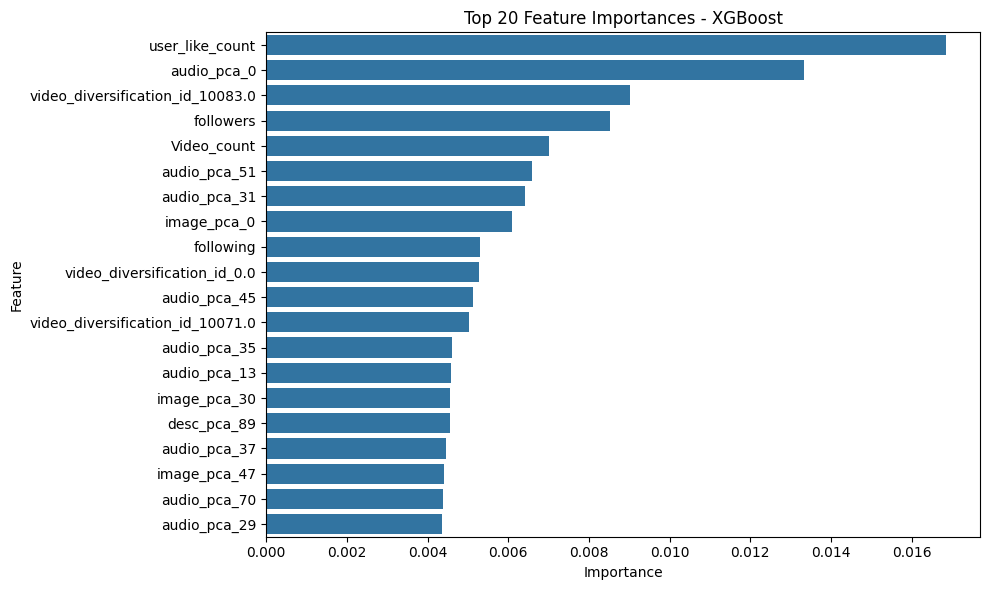

In [29]:
# Feature importance for XGBoost
feature_importances_xgboost = pd.DataFrame({'feature': X_train.columns, 'importance': best_model.feature_importances_})
feature_importances_xgboost = feature_importances_xgboost.sort_values('importance', ascending=False)
print("\nTop 20 Feature Importances XGBoost:")
print(feature_importances_xgboost.head(20))

# Plot top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances_xgboost.head(20))
plt.title('Top 20 Feature Importances - XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()